# HIV Inhibitor Prediction Using Graph Neural Networks (GNN) on Amazon SageMaker

## Learning Objectives

    * Understand the basics of Graph Neural Networks and how they can be applied to molecular graphs
    * Learn how to use the Deep Graph Library
    * Understand how to build, train, and deploy a DGL-model on SageMaker
    * Hyperparameter Tuning of deep-learning models.
    * Using Bring-Your-Own Script with SageMaker for training custom models
    * Use SageMaker Experiments to track experiment results


## Introduction :

Human immunodeficiency virus type 1 (HIV-1) is the most common cause of Acquired Immunodeficiency Syndrome (AIDS), and an ongoing area of research is to determine compounds that inhibit HIV-1 viral replication.  Schematically, this is shown below as:

![Inhibitor](img/1.jpg)
<div style="text-align: center">
<font size=1> 
Image Source : Biological evaluation of molecules of the azaBINOL class as antiviral agents (https://www.sciencedirect.com/science/article/abs/pii/S0968089619306704)
 </font>
</div>

<br/>
<br/>
<br/>



### Why is Deep Learning being applied to biological networks?

If you are familiar with classical network analysis, you probably encountered various measures around graphs, such as the [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality), the [degree centrality](https://en.wikipedia.org/wiki/Centrality#Degree_centrality), or methods for analyzing networks, such as [random walk with restart](https://towardsdatascience.com/random-walks-with-restart-explained-77c3fe216bca). These methods have been used in the past for doing things like calculating properties of nodes, analyzing networks, or analyzing groups of disease [genes.](https://pubmed.ncbi.nlm.nih.gov/18371930/) However, many such methods that rely on these types of centralities suffer from the fact that they are **transductive,** which means that they can only be used for generating features for a particular graph. Thus, doing calculations such as edge prediction or graph classification, where many different graphs are used,  may be difficult. See [this](https://arxiv.org/abs/1706.02216) paper for further discussion of this issue.

(A quick note on nomenclature: we use the term “graphs" to refer to biological networks; we reserve the term "network" for a neural network. Although it is common in the computational biology field to refer to biological graphs as networks, in the deep learning field, "network" refers almost exclusively to a neural network).

One of the key ideas behind applying deep learning to graphs is that [convolution neural networks,](https://www.d2l.ai/chapter_convolutional-neural-networks/index.html) commonly used in computer vision, can with certain modifications also be used in the context of analyzing graphs. Convolutions, among other properties, allow for **inductive** learning, whereby features can be learned for different graph topologies.  These convolutions thus transform the underlying information in the graph nodes and edges. While a single convolutional layer is generally not sufficient for most tasks, many different convolutions can be combined to form a deep graph convolutional neural network. By using layers of graph convolutions, you can build complex neural networks that can do graph prediction (i.e., predict the class of a network), link prediction (predict missing edges in a network), as well as many other tasks. 

With deep learning models, it is also possible to incorporate different edge types as well as external information about edges and nodes. This makes deep learning an attractive approach for analyzing and making predictions about graphs, since biological networks are frequently very heterogeneous, with diverse datasets, such as metabolic, biophysical, proteomic and functional assays, and gene regulatory networks. For example, [this](https://www.amazon.science/blog/amazon-web-services-open-sources-biological-knowledge-graph-to-fight-covid-19) blog post shows how a knowledge graph with diverse node and edge types to predict drug repurposing.

While of course researchers can create their own convolutional layers, deep learning researchers have already built many convolutions and architectures that have proven useful in many applications. For example, [GraphSage](https://arxiv.org/pdf/1706.02216.pdf) can be used for predicting protein-protein interactions. Another commonly used approach is [Graph Attention Networks](https://arxiv.org/pdf/1710.10903.pdf) (GAT).

For a deeper overview of deep graph learning, and how it is being used to analyze biological data, see [this](https://academic.oup.com/bib/article/22/2/1515/5964185) review paper. You may also find [this](http://snap.stanford.edu/deepnetbio-ismb/) tutorial useful.

### What is the Deep Graph Library (DGL)? When Should you Use it?

Simply put, Deep Graph Library (DGL) allows researches and developers to easily and quickly apply deep graph learning approaches to their data by abstracting away much of the difficult deep learning work and code.  The DGL library comes with a number of prebuilt layers, so that researchers don’t have to reimplement these themselves. For example, [this](https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.SAGEConv.html#dgl.nn.pytorch.conv.SAGEConv) page shows the method call within DGL for using the GraphSage convolution, while [this](https://docs.dgl.ai/generated/dgl.nn.pytorch.conv.GATConv.html#dgl.nn.pytorch.conv.GATConv) page shows the method call for GAT. You can take a look at the many other convolutions DGL already has [here](https://docs.dgl.ai/api/python/nn-pytorch.html). Of course, you have the flexibility to create your own layers and architectures as well.  

Furthermore, the [DGL-LifeScience](https://lifesci.dgl.ai/index.html) python package provides an even further abstraction of DGL, so that computational biologists, biochemists, and bioinformaticians who wish to leverage deep graph methods can easily do so for certain common use cases and performing common operations in the context of analyzing small and large molecules. If you want to learn more about how to use the DGL library, we recommend getting started with [this](https://docs.dgl.ai/en/0.6.x/guide/graph.html) tutorial.


## Notebook Overview

This example notebook focuses on training multiple Graph neural network models using Deep Graph Library and deploying it using Amazon SageMaker, which is a  comprehensive and fully managed machine learning service. With SageMaker, data scientists and developers can quickly and easily build and train machine learning models, and then directly deploy them into a production-ready hosted environment. 

**Note:** Please select the Kernel as Python 3 (Pytorch 1.6 Python 3.6 CPU Optimized).



### Setup

Let's start by installing dgl libraries latest sagemaker version and importinn some Python libraries.

In [ ]:
%pip install --quiet dgl
%pip install --quiet dgllife
%pip install -U --quiet sagemaker=="2.75.1"
%pip install --quiet rdkit-pypi

In [ ]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

import dgl

from dgllife.model import load_pretrained
from dgllife.utils import smiles_to_bigraph, EarlyStopping, Meter, CanonicalAtomFeaturizer, CanonicalBondFeaturizer
from functools import partial
from torch.optim import Adam
from torch.utils.data import DataLoader

from dgllife.data import HIV

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

In [4]:
rdkit.__version__

'2021.09.4'

In [5]:
node_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
edge_featurizer = None#CanonicalBondFeaturizer(bond_data_field='feat1')
num_workers = 1
split_ratio = "0.7:0.2:0.1"

### Dataset

The Drug Therapeutics Program AIDS Antiviral Screen has tested the ability of 43,850 compounds to inhibit viral replication. You can read more about this dataset and the assays [here](https://wiki.nci.nih.gov/display/NCIDTPdata/AIDS+Antiviral+Screen+Data). The DGL library has a pre-processed version of this dataset where each compound is classified as either Confirmed Inactive (CI; labeled as 0) or Confirmed Moderately Active/Confirmed Active (CM,CA; labeled as 1). If you download and inspect the raw dataset from [here](https://moleculenet.org/datasets-1) (you can download a csv using [this](https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv) link) you will see the data looks something like this:


|smiles |activity |HIV_active |
|---  |---  |---  |
|CC(C)(CCC(=O)O)CCC(=O)O  |CI |0  |
|O=C(O)Cc1ccc(SSc2ccc(CC(=O)O)cc2)cc1 |CM |1  |
|O=C(O)c1ccccc1SSc1ccccc1C(=O)O |CI |0  |
|CCCCCCCCCCCC(=O)Nc1ccc(SSc2ccc(NC(=O)CCCCCCCCCCC)cc2)cc1 |CI |0  | 

Since Confirmed Inactive compounds are labeled 0, while  Confirmed Moderately Active/Confirmed Active are labeled 1, this problem is a **graph classification problem**. Each molecule (which is described as a [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) string) will be constructed as a graph, with the goal of classifying each molecule as either active or inactive. In this graph, each atom is a node, and an edge is a bond between two atoms. 

In [ ]:
dataset = HIV(smiles_to_graph=partial(smiles_to_bigraph, add_self_loop=True),
                  node_featurizer=node_featurizer,
                  edge_featurizer=edge_featurizer,
                  n_jobs=num_workers)

In [7]:
type(dataset)

dgllife.data.hiv.HIV

### Explore the dataset

In [8]:
dataset.df.shape

(41127, 2)

In [9]:
dataset.df.head(15)

,smiles,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,0
4,O=S(=O)(O)CCS(=O)(=O)O,0
5,CCOP(=O)(Nc1cccc(Cl)c1)OCC,0
6,O=C(O)c1ccccc1O,0
7,CC1=C2C(=COC(C)C2C)C(O)=C(C(=O)O)C1=O,0
8,O=[N+]([O-])c1ccc(SSc2ccc([N+](=O)[O-])cc2[N+]...,0
9,O=[N+]([O-])c1ccccc1SSc1ccccc1[N+](=O)[O-],0


* Dataset containes ~41K molecules in `smiles` format.
* The `HIV_active` column (label) indicates that the molecule is a suitable HIV inhibitor or not. 

First, let's verify if there are any missing values in the dataset.

In [ ]:
dataset.df.info()

In [11]:
dataset.df.isnull().values.any()

False

As you can see, there are `no` missing values in this dataset. Then let's explore the class distribution of the dataset.

In [12]:
dataset.df['HIV_active'].value_counts()

0    39684
1     1443
Name: HIV_active, dtype: int64

<AxesSubplot:>

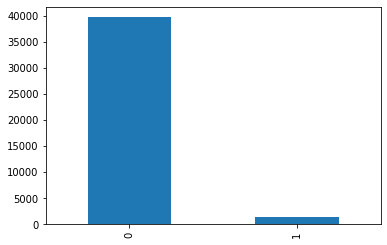

In [13]:
dataset.df['HIV_active'].value_counts().plot(kind='bar')

* Dataset is heavily imbalaced as there are only ~3% compounds screened as HIV inhibtiors.

### Explore Moleculular Properties (with RDKit)

The [RDKit](https://www.rdkit.org/docs/cppapi/index.html) is an open-source cheminformatics toolkit. It includes a collection of standard cheminformatics functionality for molecule I/O, substructure searching, chemical reactions, coordinate generation (2D or 3D), fingerprinting, etc.

We are going to use this library to explore the molecules (presented in smiles format) in the dataset. Following are few ramdomly selected molecules from the dataset visualized using RDKit



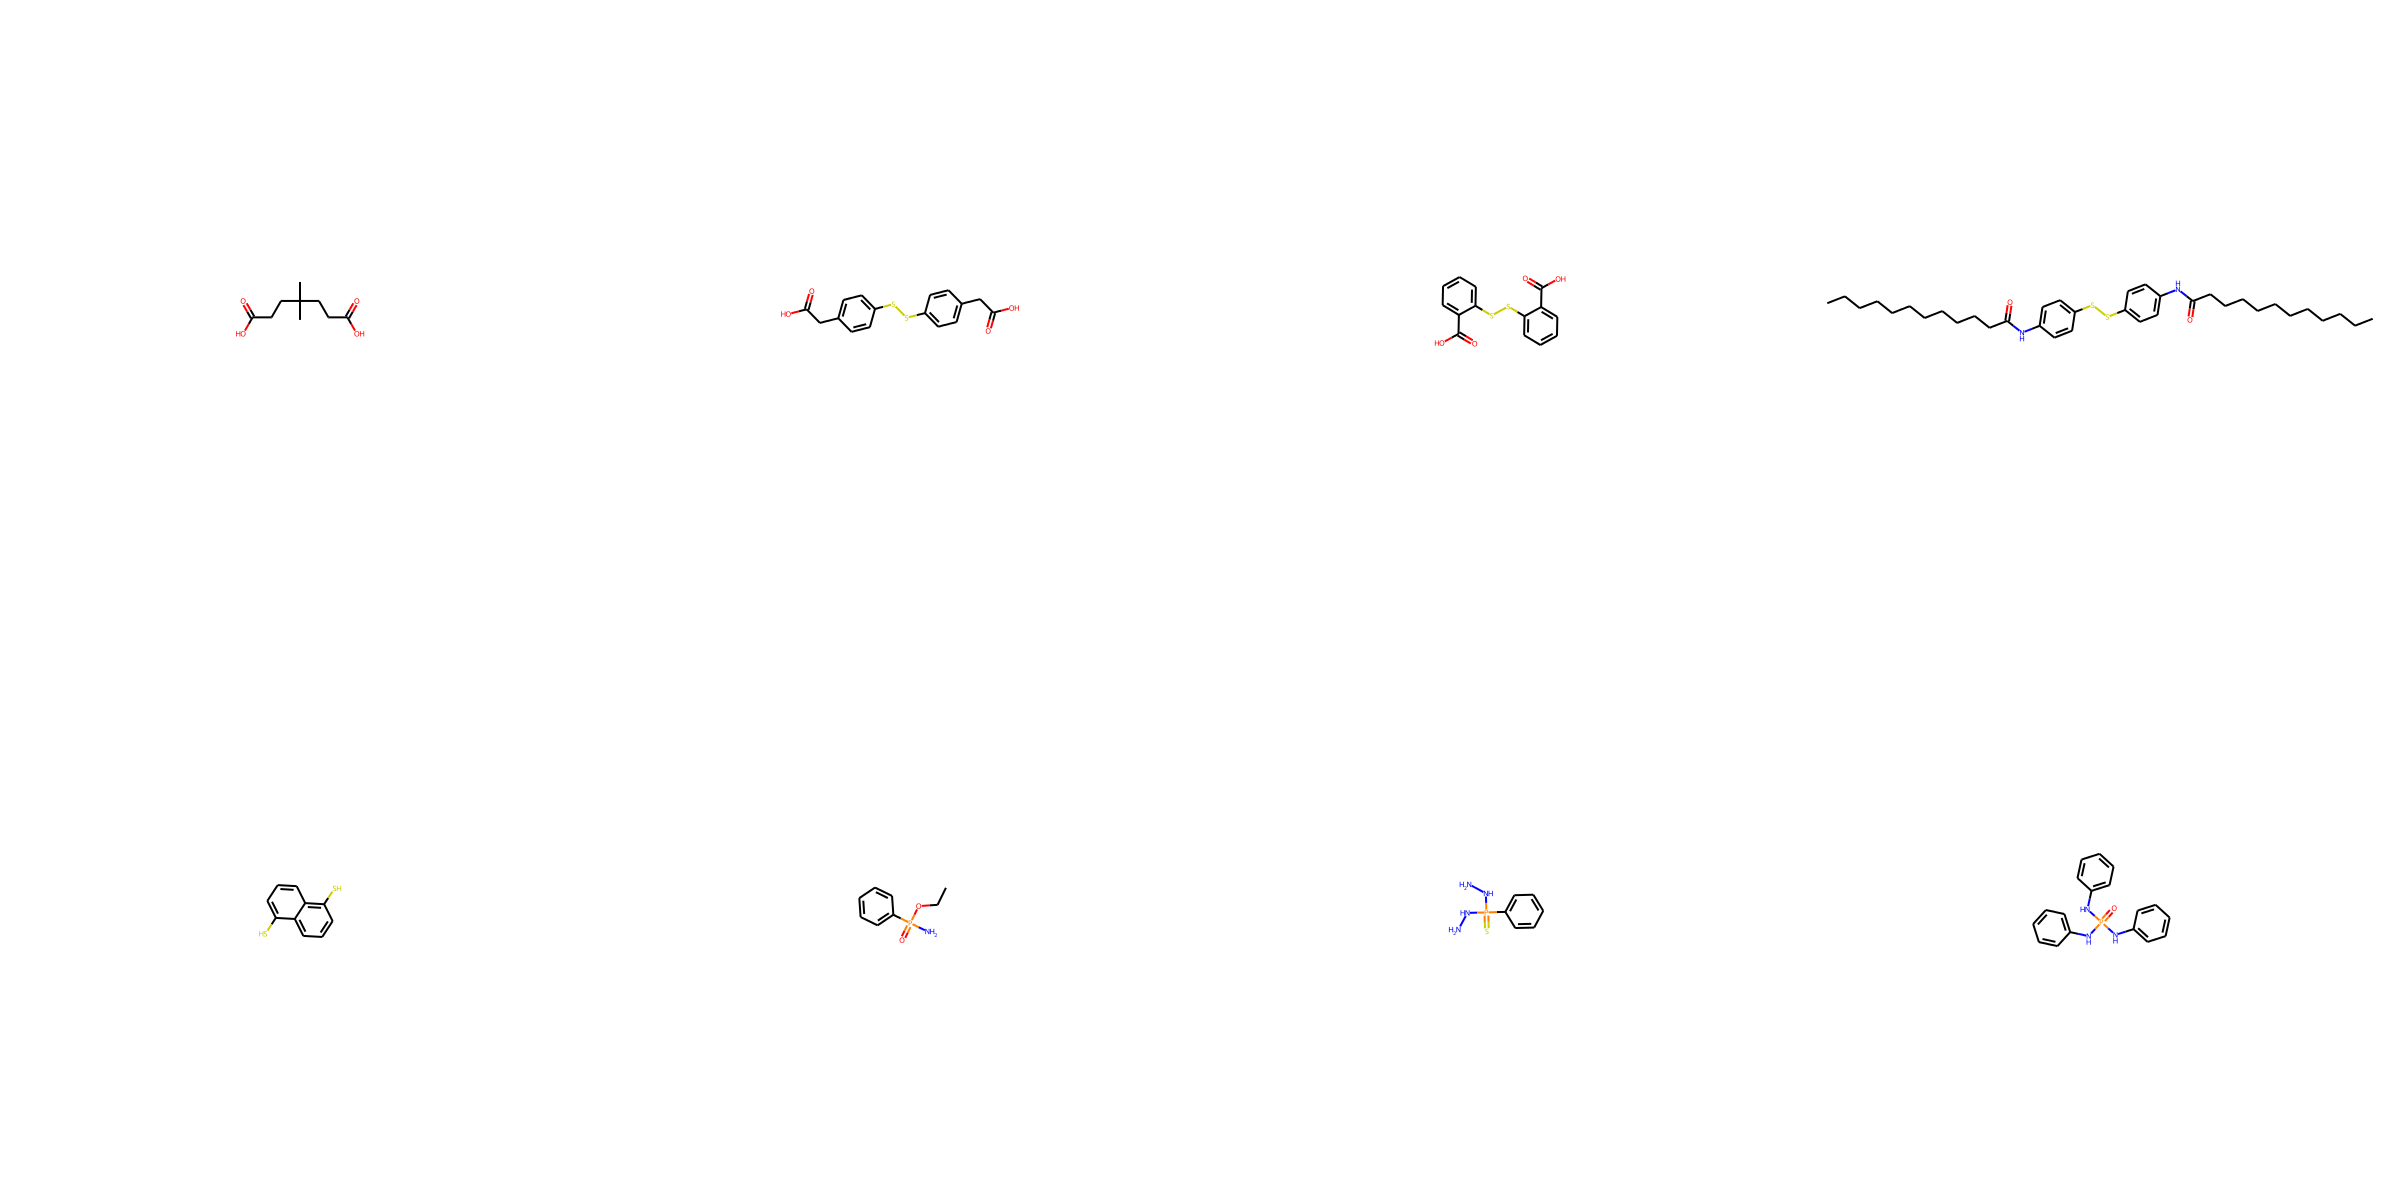

In [68]:
random_molecule_start_index = 10

sample_smiles = dataset.df['smiles'][random_molecule_start_index:random_molecule_start_index + 8].values
sample_molecules = [Chem.MolFromSmiles(smile) for smile in sample_smiles]
Draw.MolsToGridImage(sample_molecules, molsPerRow=4, subImgSize=(600, 600))

* Let's look at a single molecule and explore the properties.

In [15]:
sample_smiles[0]

'CC(C)(CCC(=O)O)CCC(=O)O'

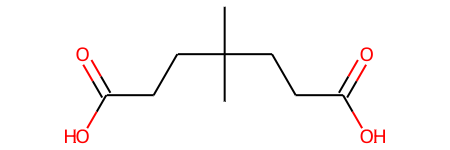

In [16]:
mol = sample_molecules[0]
mol

* Using the methods here we can further explore the features of the molecules.
https://www.rdkit.org/docs/cppapi/classRDKit_1_1Atom.html

In [17]:
atoms = mol.GetAtoms()
print("Total number of atoms in the molecule : {}".format(len(atoms)))

Total number of atoms in the molecule : 13


In [ ]:
molecule_features = []
for atom in atoms:
    atom_features = {}
    atom_features['atomic_symbol'] = atom.GetSymbol()
    atom_features['atomic_numbers'] = atom.GetAtomicNum()
    atom_features['degree'] = atom.GetDegree()
    atom_features['formal_charge'] = atom.GetFormalCharge()
    atom_features['hybridization'] = atom.GetHybridization()
    atom_features['is_aromatic'] = atom.GetIsAromatic()
    molecule_features.append(atom_features)
molecule_features

* We can apply node-fearizer directly into the molecule like below and generate above results.

In [ ]:
atom_featurizer = CanonicalAtomFeaturizer(atom_data_field='feat')
atom_featurizer(mol)

In [20]:
atom_featurizer.feat_size()

74

We already have these embedded to our graph since we have used the node featurizer at the top. 

https://lifesci.dgl.ai/generated/dgllife.utils.CanonicalAtomFeaturizer.html

Let's decode the graph associated to above index

In [21]:
smiles, graphs, labels, masks = map(list, zip(*dataset))

In [22]:
smiles[random_molecule_start_index]

'CC(C)(CCC(=O)O)CCC(=O)O'

In [23]:
random_graph = graphs[random_molecule_start_index]

random_graph.num_nodes()

13

In [24]:
random_graph.num_edges()

37

In [25]:
random_graph.ndata['feat'].shape

torch.Size([13, 74])

In [26]:
random_graph.ndata['feat'][0, :]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 0.])

In [27]:
random_graph.ndata['feat'][1, :]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])

Order of the atoms represented in the graph is different (This is a not an problem). 

### Split the dataset

DGL-LifeSci provides interfaces to split your data for train, validation and test sets based on the strategy that you prefer. 
More details : https://lifesci.dgl.ai/api/utils.splitters.html

We are going to use the Scaffold Splitter for this project. 

**ScaffoldSplitter**:

Group molecules based on their scaffolds and sort groups based on their sizes. The groups are then split for k-fold cross validation.

Same as usual k-fold splitting methods, each molecule will appear only once in the validation set among all folds. In addition, this method ensures that molecules with a same scaffold will be collectively in either the training set or the validation set for each fold. Scaffold splitting, rather than random splitting, is commonly used in chemoinformatics to ensure that molecules that are very similair to the training set also appear in the testing set.

In [ ]:
#Split the dataset
from dgllife.utils import ScaffoldSplitter, RandomSplitter

train_ratio, val_ratio, test_ratio = map(float, split_ratio.split(':'))

train_set, val_set, test_set = ScaffoldSplitter.train_val_test_split(
            dataset, frac_train=train_ratio, frac_val=val_ratio, frac_test=test_ratio,
            scaffold_func='smiles')

* Lets check the distribution of classes of train, validation, test datasets after the split.

In [29]:
len(train_set)

28788

In [ ]:
train_set.dataset.df.loc[train_set.indices]['HIV_active'].value_counts().plot(kind="bar")

In [31]:
len(val_set)

8226

In [ ]:
val_set.dataset.df.loc[val_set.indices]['HIV_active'].value_counts().plot(kind="bar")

In [33]:
len(test_set)

4113

In [ ]:
test_set.dataset.df.loc[test_set.indices]['HIV_active'].value_counts().plot(kind="bar")

* All three datasets (train, test, validation) follows the same data distrubtions in terms of class balance.

## Using DGL in Amazon Sagemaker with Pytorch backend.

#### Set up the environment and create the session

Here we specify a bucket to use and the role that will be used for working with SageMaker. The session remembers our connection parameters to SageMaker.


In [35]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
session = sagemaker.Session()
bucket = session.default_bucket()

s3_prefix = "./hiv_inhibitor_prediction/sagemaker"

### Upload Data to S3
In order to accomodate model training on SageMaker we need to upload the data to s3 location. We are going to use the sagemaker.Session.upload_data function to upload our datasets to an S3 location. The return value inputs identifies the location -- we will use later when we start the training job.

In [36]:
dataset.df.to_csv("full.csv", index=False)
pd.DataFrame(train_set.indices, columns =["indices"]).to_csv("train.csv", index=False)
pd.DataFrame(val_set.indices, columns =["indices"]).to_csv("validation.csv", index=False)

In [37]:
input_full = session.upload_data(
        path="full.csv", bucket=bucket, key_prefix=s3_prefix
    )

input_train = session.upload_data(
        path="train.csv", bucket=bucket, key_prefix=s3_prefix
    )
input_val = session.upload_data(
        path="validation.csv", bucket=bucket, key_prefix=s3_prefix
    )

### Explore the model architectures to be used 

We are going to represent each of the modelcule as a graph. Each atom in the molecule would be a node within the graph. Hence the atom properties will be considered as node features after doing some transformations. Using these features we are going to classify the whole graph/molecule whether a it inhibits HIV virus replication or not using Graph neural networks (GNNs). In GNN terms this is considered as Graph classification problem.

We are going to use above prebuilt model architecures (GCN, GAT) which comes with DGL-LifeSci to train the model.


**1. GCNPredictor** : 

Documentation : https://lifesci.dgl.ai/_modules/dgllife/model/model_zoo/gcn_predictor.html

Code : https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/model/model_zoo/gcn_predictor.py

In [38]:
from dgllife.model import GCNPredictor
import torch.nn.functional as F

model = GCNPredictor(
            in_feats=10,
            hidden_feats=[10, 4],
            activation=[F.relu, F.relu],
            residual=[False] * 2
            )

In [39]:
model

GCNPredictor(
  (gnn): GCN(
    (gnn_layers): ModuleList(
      (0): GCNLayer(
        (graph_conv): GraphConv(in=10, out=10, normalization=none, activation=<function relu at 0x7f4e630007b8>)
        (dropout): Dropout(p=0.0, inplace=False)
        (bn_layer): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): GCNLayer(
        (graph_conv): GraphConv(in=10, out=4, normalization=none, activation=<function relu at 0x7f4e630007b8>)
        (dropout): Dropout(p=0.0, inplace=False)
        (bn_layer): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (readout): WeightedSumAndMax(
    (weight_and_sum): WeightAndSum(
      (atom_weighting): Sequential(
        (0): Linear(in_features=4, out_features=1, bias=True)
        (1): Sigmoid()
      )
    )
  )
  (predict): MLPPredictor(
    (predict): Sequential(
      (0): Dropout(p=0.0, inplace=False)
      (1): Linear(in_features=8, out_features=128,

As you can see `GCNPredictor` architecture compised of multple layers of `gnn_layers` which itself comprised of DGL `GraphConv`.

## Training on SageMaker



#### Training Script

We are going to use Pytorch as the DGL backend. Our training script should save model artifacts learned during training to a file path called model_dir, as stipulated by the SageMaker PyTorch image. Upon completion of training, model artifacts saved in model_dir will be uploaded to S3 by SageMaker and will be used for deployment.

We save this script in a file named train.py, and put the file in a directory named code/. The full training script can be viewed under code/.
    
    

In [ ]:
!cat code/train.py

#### Create an experiment

When training with SageMaker it is a good idea to track all the trails that we do to come up with better model under a single colelction. Hence later we would be able compare each of the trails. That colelction is called SageMaker experiments.

In [ ]:
%pip install sagemaker-experiments --quiet

In [ ]:
from smexperiments.experiment import Experiment

experiment_name = "HIV-Inhibitor-Prediction-Experiment"

try :
    experiment = Experiment.load(experiment_name)
except Exception as e:
    if e.response['Error']['Code'] == "ResourceNotFound":
        print("Experiment name [{}], does not exists. Hence creating.".format(experiment_name))
        experiment = Experiment.create(experiment_name = experiment_name,
                                description = "Experiment to track all the hiv inhibitr prediction trails.")
    else:
        raise e
experiment                               

#### Define hyper parameters

Next, let's define hyper parameters assocated with the model. As per training script we created above here are some of the hyper parameters that we can use to tune our model(s). One highlight here is that the model architecture is also given here as the hyper parameter which allows other model architecutures like GAT, MPNN. 

In [43]:
from sagemaker.pytorch import PyTorch
import time

hyperparameters={
    # Feature Engineering
    "gnn-featurizer-type": 'canonical',
    
    # Model Architecture
    "gnn-model-name" : 'GCN-p',
    "gnn-residuals" : False,
    "gnn-batchnorm" : True,
    "gnn-dropout" : 0.0013086019242321,
    "gnn-predictor-hidden-feats" : 512,
    
    # Training
    "batch-size" : 512,
    "epochs" : 20,
    "learning-rate" : 0.000508635928951698,
    "weight-decay" : 0.0013253058161908312,
    "patience" : 30
}

metric_definitions =[
                   {'Name': 'train:roc_auc_score', 'Regex': 'training:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'validation:roc_auc_score', 'Regex': ',\svalidation:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'best validation:roc_auc_score', 'Regex': 'best\svalidation:roc_auc_score\s\[([0-9\\,.]+)\]'},
                   {'Name': 'epoch', 'Regex': 'epoch\s\[([0-9]+)\]'},
                   {'Name': 'train:loss', 'Regex': 'loss\s\[([0-9\\,.]+)\]'}
                ]



#### Create trial

From here onwards each model training that we are going to perform will be tracked under the experiement that we created above as a seperate trail.

In [44]:
trial_name = "hiv-inhibitor-prediction-training-{}-{}".format(hyperparameters["gnn-model-name"], time.strftime("%m-%d-%Y-%H-%M-%S"))
trial = experiment.create_trial(trial_name=trial_name)

### Train

DGL expects a neural network runtime and supports all Tensorlow, Pytorch and MxNext as it's runtimes. For for this project we are going to use `Pytorch` as the backend.

The Amazon SageMaker Python SDK makes it easier to run a PyTorch script in Amazon SageMaker using its PyTorch estimator. After that, we can use the SageMaker Python SDK to deploy the trained model and run predictions. For more information on how to use this SDK with PyTorch, see the SageMaker Python SDK documentation.

To start, we use the PyTorch estimator class to train our model. When creating our estimator, we make sure to specify a few things:

* `entry_point`: the name of our PyTorch script. It contains our training script, which loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model. It also contains code to load and run the model during inference.

* `source_dir`: the location of our training scripts and requirements.txt file. "requirements.txt" lists packages you want to use with your script.

* `framework_version`: the PyTorch version we want to use.
The PyTorch estimator supports both single-machine & multi-machine, distributed PyTorch training using SMDataParallel

In [ ]:
training_job_name = "tr-{}".format(trial_name) 
print('Training job name: ', training_job_name)

estimator = PyTorch(
    entry_point = "train.py",
    source_dir = "code",
    role = role,
    framework_version = "1.9.0",
    py_version="py38",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    debugger_hook_config=False,
    disable_profiler=True,
    hyperparameters = hyperparameters,
    metric_definitions=metric_definitions
)

estimator.fit({"data_full" : input_full, "data_train" : input_train, "data_val" : input_val}, 
              job_name = training_job_name,
             experiment_config = {
                    # "ExperimentName"
                    "TrialName" : trial.trial_name,
                    "TrialComponentDisplayName" : "TrainingJob",
                })

### Training results :

* As you can see with the initial training here we get about 76% AUC value. How the metrics like training loss, validation loss and roc score changed over the time can be viewed on the SageMaker experiements.

Before, we deploy the model to an endpoint, let's see the where the model trained arffacts are stored in S3.


In [46]:
#model_data='s3://sagemaker-us-west-2-431678540810/tr-hiv-inhibitor-prediction-training-GCN-p-02-27-2022-22-25-51/output/model.tar.gz'
model_data = estimator.model_data
print("Stored {} as model_data".format(model_data))

Stored s3://sagemaker-us-east-1-111918798052/tr-hiv-inhibitor-prediction-training-GCN-p-11-01-2022-14-48-05/output/model.tar.gz as model_data


## Deploy the model on Amazon SageMaker
After training our model, we host it on an Amazon SageMaker Endpoint. To make the endpoint load the model and serve predictions, we implement a few methods in inference.py.

* `model_fn()`: function defined to load the saved model and return a model object that can be used for model serving. The SageMaker PyTorch model server loads our model by invoking model_fn.
* `input_fn()`: deserializes and prepares the prediction input. In this example, our request body is first serialized to JSON and within the JSON it expects the `smiles` of the molecules that needs to be predicted. The input of smiles first converts graph using DGL and then add the features to each node using the same featurizer used at the time of training. Then the graph with features is returned by this function which is the requested format by the model. 
* `predict_fn()`: performs the prediction and returns the result. To deploy our endpoint, we call deploy() on our PyTorch estimator object, passing in our desired number of instances and instance type:

In [47]:
from sagemaker.pytorch import PyTorchModel

endpoint_name = "HIV-Inhibitor-Prediction-EP-{}".format(time.strftime("%m-%d-%Y-%H-%M-%S"))
print("Endpoint name: ", endpoint_name)

model = PyTorchModel(model_data=model_data, source_dir='code',
                        entry_point='inference.py', role=role, framework_version="1.9.0", py_version='py38')



Endpoint name:  HIV-Inhibitor-Prediction-EP-11-01-2022-15-02-09


In [48]:
predictor = model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge", endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: pytorch-inference-2022-11-01-15-02-10-632
INFO:sagemaker:Creating endpoint-config with name HIV-Inhibitor-Prediction-EP-11-01-2022-15-02-09
INFO:sagemaker:Creating endpoint with name HIV-Inhibitor-Prediction-EP-11-01-2022-15-02-09


------!

## Predicting test_set with the endpoint :

As our newly created endpoint expects the smiles as the input let's get the all the smiles of the test_set. We can use followng function for that.

In [49]:
def collate_molgraphs(data):
    """Batching a list of datapoints for dataloader.
    Parameters
    ----------
    data : list of 4-tuples.
        Each tuple is for a single datapoint, consisting of
        a SMILES, a DGLGraph, all-task labels and optionally a binary
        mask indicating the existence of labels.
    Returns
    -------
    smiles : list
        List of smiles
    bg : DGLGraph
        The batched DGLGraph.
    labels : Tensor of dtype float32 and shape (B, T)
        Batched datapoint labels. B is len(data) and
        T is the number of total tasks.
    masks : Tensor of dtype float32 and shape (B, T)
        Batched datapoint binary mask, indicating the
        existence of labels.
    """

    smiles, graphs, labels, masks = map(list, zip(*data))
    
    bg = dgl.batch(graphs)
    bg.set_n_initializer(dgl.init.zero_initializer)
    bg.set_e_initializer(dgl.init.zero_initializer)
    labels = torch.stack(labels, dim=0)
    masks = torch.stack(masks, dim=0)

    return smiles, bg, labels, masks

Using that function let's get all the smiles in the test set.

In [50]:
test_smiles, bg, test_labels, masks = collate_molgraphs(test_set)

### Predicting for a single molecule :

Let's use single molecule from the test set and predict the probability of its beeing and inhibitor using the newly created endpoint above. Here is a randomly selected molecule. 

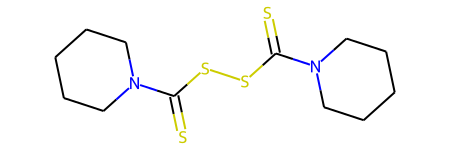

In [51]:
mol = Chem.MolFromSmiles(test_smiles[110])
mol

Let's send this molecule data as JSON format to the endpoint and get the results.

In [52]:
from sagemaker.predictor import Predictor

predictor = Predictor(endpoint_name=endpoint_name)

predictor.serializer = sagemaker.serializers.JSONSerializer()
predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

In [53]:
json = {
    "smiles" : 
        [test_smiles[110]]
}

prediction_logits = predictor.predict(json)
prediction_logits

[-5.051063060760498]

This had returned the logit value of above molecule beeing considered as an inhibitor.

### Predicting for a for whole test_set :


In [54]:
json = {
    "smiles" : 
        test_smiles
}

prediction_logits = predictor.predict(json)

### Examine the test results 

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt 

roc_auc_score(test_labels[:,0].numpy(), np.asarray(prediction_logits))

0.7127986249251627

* We get the ROC/AUC score for test set with the initial model aroinf 0.75.
* Below is the ROC Curve

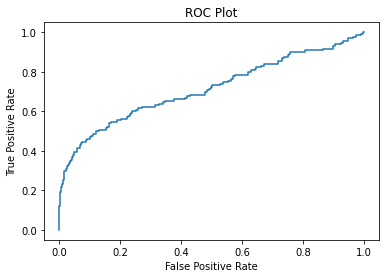

In [56]:
fpr, tpr, _ = roc_curve(test_labels[:,0].numpy(), np.asarray(prediction_logits))

plt.plot(fpr, tpr)
plt.title("ROC Plot")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Hyper parameter tunning 

So far we have trained a single model with fixed hyper parameters. Next lets try to further optimize the model by trying out different hyper-parameters. We can use [Amazon SageMaker Hyper-parameter tuner](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html) for this purpose.

In [ ]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
gcn_hyperparameter_ranges = {
    
    "gnn-dropout": ContinuousParameter(0.001 , 0.003),
    "gnn-predictor-hidden-feats" : CategoricalParameter([128, 256, 512]),
    
    "batch-size" :  CategoricalParameter([256, 512]),
    "learning-rate" : ContinuousParameter(0.0001, 0.001),
    "weight-decay" : ContinuousParameter(0.001, 0.01)
    
}

objective_metric_name = "best validation:roc_auc_score"

gcn_estimator = PyTorch(
    entry_point = "train.py",
    source_dir = "code",
    role = role,
    framework_version = "1.9.0",
    py_version="py38",
    instance_count=1,
    instance_type="ml.g4dn.4xlarge",
    debugger_hook_config=False,
    disable_profiler=True
)

gcn_tuner = HyperparameterTuner(
    gcn_estimator,
    objective_metric_name,
    gcn_hyperparameter_ranges,
    metric_definitions,
    max_jobs=1,
    max_parallel_jobs=1
)

hyper_parameter_job_name = "hpo-hiv-gcn-p-{}".format(time.strftime("%m-%d-%H-%M-%S")) 
print('Training job name: ', hyper_parameter_job_name)

gcn_tuner.fit({"data_full" : input_full, "data_train" : input_train, "data_val" : input_val}, job_name = hyper_parameter_job_name)


In [60]:
# if the notebook lost it's connection, you can attach the tunner job by attaching the name below.
#gcn_tuner = HyperparameterTuner.attach("hpo-hiv-gcn-p-03-16-02-38-07")


Let's examine the best model and it's hyper parameters.

In [ ]:
import boto3

smclient = boto3.client("sagemaker")

best_overall_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=hyper_parameter_job_name
)

best_overall_training_job["BestTrainingJob"]

In [62]:
best_gcn_training_job = sagemaker.estimator.Estimator.attach(best_overall_training_job["BestTrainingJob"]["TrainingJobName"])


2022-11-01 15:38:47 Starting - Preparing the instances for training
2022-11-01 15:38:47 Downloading - Downloading input data
2022-11-01 15:38:47 Training - Training image download completed. Training in progress.
2022-11-01 15:38:47 Uploading - Uploading generated training model
2022-11-01 15:38:47 Completed - Resource retained for reuse


In [ ]:
best_gcn_model = PyTorchModel(model_data=best_gcn_training_job.model_data, source_dir='code',
                        entry_point='inference.py', role=role, framework_version="1.9.0", py_version='py38')

best_gcn_predictor = best_gcn_model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge", endpoint_name="best-gcn-" + endpoint_name)

In [64]:
best_gcn_predictor.serializer = sagemaker.serializers.JSONSerializer()
best_gcn_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

json = {
    "smiles" : 
        test_smiles
}

prediction_logits = best_gcn_predictor.predict(json)
roc_auc_score(test_labels[:,0].numpy(), np.asarray(prediction_logits))

0.7573688174742657

## Clean up 

Lastly, please remember to delete the Amazon SageMaker endpoint to avoid charges:

In [ ]:
best_gcn_predictor.delete_endpoint()

In [ ]:
predictor.delete_endpoint()